In [4]:
#TODO: PCA

from data_helper_wine import get_dataloaders_and_standarscaler_wine
from train_helper_wine import train_autoencoder
from plot_helper_wine import plot_training_loss

import copy

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn

In [5]:
CUDA_DEVICE_NUM=0
DEVICE = torch.device(f'cuda:{CUDA_DEVICE_NUM}' if torch.cuda.is_available() else 'cpu')
DEVICE='cpu'
print('Device:', DEVICE)


Device: cpu


In [6]:
#ODCZYTANIE DANYCH OFFLINE
path='DATA/wine.data'
df_wine = pd.read_csv('DATA/wine.data', header=None)

df_wine.columns = ['Class label', 'Alcohol', 'Malic acid', 'Ash',
                   'Alcalinity of ash', 'Magnesium', 'Total phenols',
                   'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins',
                   'Color intensity', 'Hue', 'OD280/OD315 of diluted wines',
                   'Proline']

df_wine.head()#zawsze warto rzucić okiem na dane

,Class label,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [7]:
#sns.pairplot(df_wine.iloc[:,1:])

In [8]:
# Hyperparameters
#RANDOM_SEED = 123
LEARNING_RATE = 0.0005
BATCH_SIZE = 8
NUM_EPOCHS = 150

In [9]:
train_loader, valid_loader, test_loader, stdcs = get_dataloaders_and_standarscaler_wine(path=path,
    batch_size=BATCH_SIZE, 
    num_workers=0,
    test_fraction=0.2, 
    validation_fraction=0.0)

In [10]:
#SRAWDZENIE ZBIORU DANYCH
print('Training Set:\n')
for images, labels in train_loader:  
    print('Batch dimensions:', images.size())
    print('Label dimensions:', labels.size())
    print(labels[:10])
    break
    
print('\nValidation Set:')
for images, labels in valid_loader:  
    print('Batch dimensions:', images.size())
    print('Label dimensions:', labels.size())
    print(labels[:10])
    break

print('\nTesting Set:')
for images, labels in test_loader:  
    print('Batch dimensions:', images.size())
    print('Label dimensions:', labels.size())
    print(labels[:10])
    break

Training Set:

Batch dimensions: torch.Size([8, 13])
Label dimensions: torch.Size([8])
tensor([2., 3., 3., 1., 1., 3., 1., 2.])

Validation Set:

Testing Set:
Batch dimensions: torch.Size([8, 13])
Label dimensions: torch.Size([8])
tensor([2., 1., 2., 1., 2., 3., 3., 1.])


In [11]:
#TWORZENIE ITERATORA PRZYDATNEGO W PĘTLI UCZĄCEJ MODELU
dataiter_train=iter(train_loader)
data_train=dataiter_train.next()
features_train, labels_train = data_train

print(features_train.shape)

#TWORZENIE ITERATORA ZBIORU TESTOWEGO 
dataiter_test=iter(test_loader)
data_test=dataiter_test.next()
features_test, labels_test = data_test

torch.Size([8, 13])


In [12]:
class Autoencoder_Linear(nn.Module):
    def __init__(self):
        super().__init__()        
        self.encoder = nn.Sequential(
            nn.Linear(13, 13), 
            nn.ReLU(),
            nn.Linear(13, 7),
            nn.ReLU(),
            nn.Linear(7, 3),
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(3, 7),
            nn.ReLU(),
            nn.Linear(7, 13),
            nn.ReLU(),
            nn.Linear(13, 13)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded, encoded

In [13]:
model = Autoencoder_Linear()
model.to(DEVICE)

#criterion = nn.MSELoss()#FUNKCJA STRATY
optimizer = torch.optim.Adam(model.parameters(),
                             lr=1e-3, 
                             weight_decay=1e-5)

In [14]:
log_dict=train_autoencoder(num_epochs=NUM_EPOCHS,model=model,optimizer=optimizer,train_loader=train_loader,loss_fn=None, device=DEVICE, test_loader=test_loader, logging_interval=5)

Epoch: 001/150 | Batch 0000/0017 | Loss: 0.9220
Epoch: 001/150 | Batch 0005/0017 | Loss: 0.9609
Epoch: 001/150 | Batch 0010/0017 | Loss: 1.0487
Epoch: 001/150 | Batch 0015/0017 | Loss: 1.1856
***Epoch: 001/150 | Loss: 13.236
Test***Epoch: 001/150 | Loss: 13.619
Time elapsed: 0.00 min
Epoch: 002/150 | Batch 0000/0017 | Loss: 0.9613
Epoch: 002/150 | Batch 0005/0017 | Loss: 1.0238
Epoch: 002/150 | Batch 0010/0017 | Loss: 0.8294
Epoch: 002/150 | Batch 0015/0017 | Loss: 0.9113
***Epoch: 002/150 | Loss: 13.040
Test***Epoch: 002/150 | Loss: 13.496
Time elapsed: 0.00 min
Epoch: 003/150 | Batch 0000/0017 | Loss: 0.9365
Epoch: 003/150 | Batch 0005/0017 | Loss: 0.9048
Epoch: 003/150 | Batch 0010/0017 | Loss: 1.1142
Epoch: 003/150 | Batch 0015/0017 | Loss: 0.8773
***Epoch: 003/150 | Loss: 12.638
Test***Epoch: 003/150 | Loss: 13.283
Time elapsed: 0.00 min
Epoch: 004/150 | Batch 0000/0017 | Loss: 1.0030
Epoch: 004/150 | Batch 0005/0017 | Loss: 0.7093
Epoch: 004/150 | Batch 0010/0017 | Loss: 0.9427
E

In [15]:
tmp=df_wine.to_numpy(dtype=np.float32)
#print(tmp)
tmp=tmp[:,1:]
orginal=copy.deepcopy(tmp)
tmp=stdcs.transform(tmp)
tmp=torch.from_numpy(tmp)
#print(tmp)
#tmp_label=df_wine.iloc[3,0]
with torch.no_grad():
    result, result_encoded_features=model(tmp.to(device=DEVICE))
result=result.cpu().detach().numpy()
result=stdcs.inverse_transform(result)

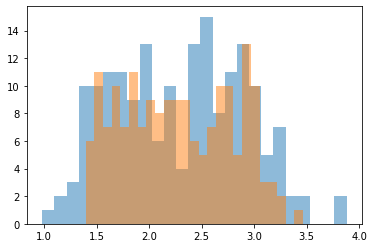

In [29]:
plt.hist(orginal[:,5],bins=25, label ='orginal',alpha=0.5)
plt.hist(result[:,5],bins=25, label ='encoded', alpha=0.5)
plt.show()

In [17]:
decoded_df=pd.DataFrame(result,columns=['Alcohol', 'Malic acid', 'Ash',
                   'Alcalinity of ash', 'Magnesium', 'Total phenols',
                   'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins',
                   'Color intensity', 'Hue', 'OD280/OD315 of diluted wines',
                   'Proline'])
orginal_df=df_wine.iloc[:,1:]


concatenated_datasets=pd.concat([orginal_df.assign(dataset_name='orginal'), decoded_df.assign(dataset_name='decoded')],ignore_index=True)
concatenated_datasets.shape
print(concatenated_datasets.index.is_unique)

True


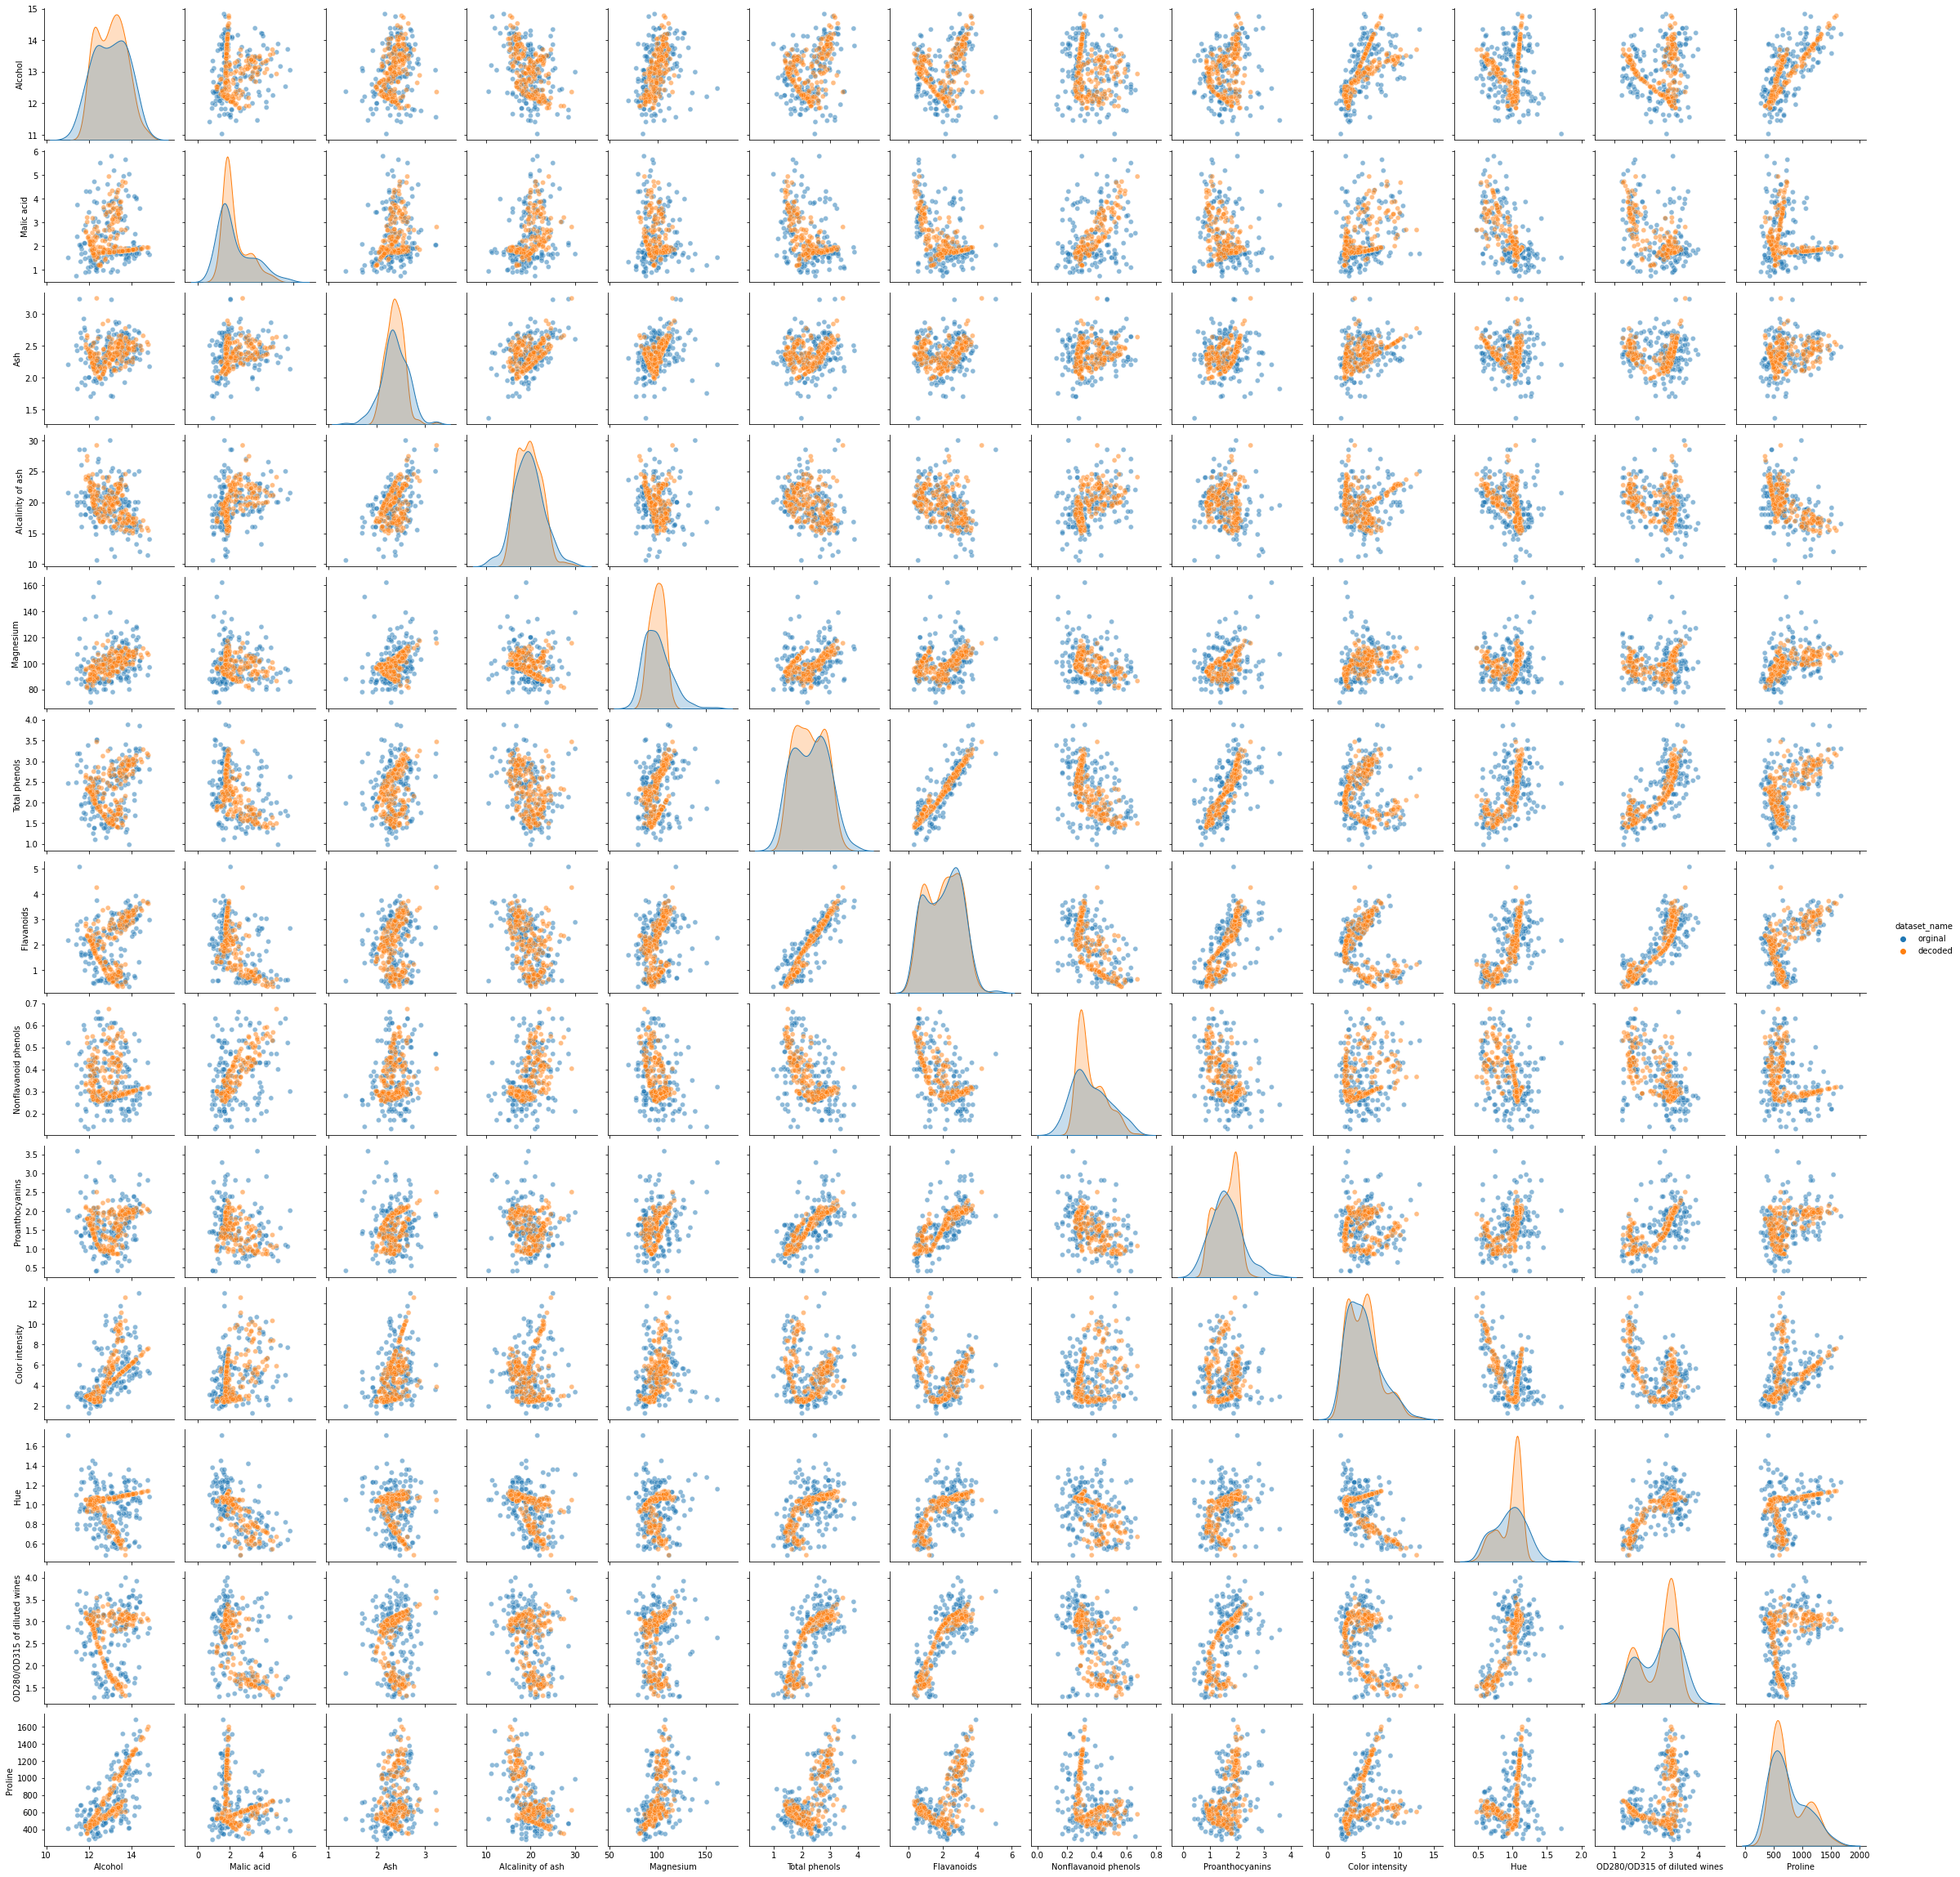

In [18]:
sns.pairplot(concatenated_datasets, hue="dataset_name", kind="scatter", plot_kws=dict(alpha=0.5))

In [19]:
# sample=concatenated_datasets.groupby('dataset_name', group_keys=False).apply(lambda x: x.sample(frac=0.05))
# sns.pairplot(sample, hue="dataset_name", diag_kind="hist", plot_kws=dict(alpha=0.5))

In [20]:
tmp_2=df_wine.iloc[37:38,1:]
tmp_2=tmp_2.to_numpy(dtype=np.float32)
orginal_2=tmp_2
tmp_2=stdcs.transform(tmp_2)
tmp_2=torch.from_numpy(tmp_2)
with torch.no_grad():
    result_2, result_encoded_features_2=model(tmp_2.to(device=DEVICE))
result_2=result_2.cpu().detach().numpy()
result_2=stdcs.inverse_transform(result_2)

In [21]:
orginal_2=orginal_2.flatten()
result_2=result_2.flatten()

In [22]:
df=pd.DataFrame(np.stack((orginal_2,result_2)), columns=['Alcohol', 'Malic acid', 'Ash',
                   'Alcalinity of ash', 'Magnesium', 'Total phenols',
                   'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins',
                   'Color intensity', 'Hue', 'OD280/OD315 of diluted wines',
                   'Proline'])
df

,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,13.050000,1.650000,2.55000,18.000000,98.000000,2.450000,2.430000,0.290000,1.440000,4.250000,1.120000,2.51000,1105.000000
1,13.311088,1.788639,2.22177,16.509356,99.861145,2.538474,2.509258,0.277935,1.787772,4.849976,1.078926,2.96062,994.529602


In [23]:
encoded_features=[]
labels_encoded_features=[]
for index, (value, labels) in enumerate(train_loader):
    with torch.no_grad():
        recon, tmp_encoded_features=model(value.to(device=DEVICE))
        encoded_features.extend(tmp_encoded_features.cpu().detach().numpy())
        labels_encoded_features.extend(labels.cpu().detach().numpy())
encoded_features=np.asarray(encoded_features)

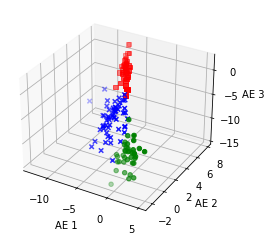

In [24]:
#PRZESTRZEŃ UKRYTA AUTOENCODERA
colors = ['r', 'b', 'g']
markers = ['s', 'x', 'o']

fig=plt.figure()
ax=fig.add_subplot(projection='3d')
for l, c, m in zip(np.unique(labels_encoded_features), colors, markers):
    ax.scatter(encoded_features[labels_encoded_features==l,0],encoded_features[labels_encoded_features==l,1],encoded_features[labels_encoded_features==l,2],marker=m,label=l,c=c)

ax.set_xlabel('AE 1')
ax.set_ylabel('AE 2')
ax.set_zlabel('AE 3')

plt.show()

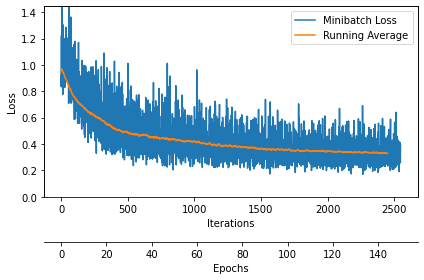

In [25]:
plot_training_loss(log_dict['train_loss_per_batch'],NUM_EPOCHS)

In [26]:
range(len(log_dict['test_loss_per_epoch']))

range(0, 150)

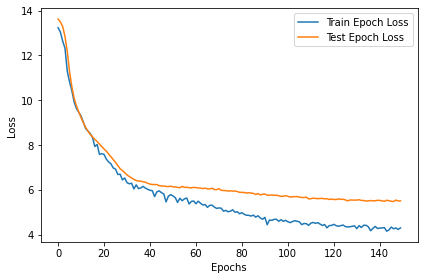

In [27]:
plt.plot(range(len(log_dict['train_loss_per_epoch'])), (log_dict['train_loss_per_epoch']), label='Train Epoch Loss')
plt.plot(range(len(log_dict['test_loss_per_epoch'])), (log_dict['test_loss_per_epoch']), label='Test Epoch Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
#plt.ylim(0.15,0.3)
plt.tight_layout()
            